## Approach 1 for clustering similar test steps in natural language

* Text embedding technique: Word2Vec
* Text similarity: Word Mover's Distance (WMD)
* Clustering techniques: Hierarchical agglomerative clustering and K-means

In [1]:
# Import necessary libraries
import os
import gc
import pandas as pd
import numpy as np
import math
import statistics as st
import re
import string
import time
import matplotlib.pyplot as plt

# For word frequency
from collections import defaultdict

# ML libraries
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import gensim
from gensim.models import Word2Vec, Phrases, KeyedVectors

# NLP libraries
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer 

# To be used with hierarchical clustering
from joblib import Memory

# To save models
import pickle

In [ ]:
# Download wordnet data through nltk
nltk.download('wordnet')

### Data preprocessing functions

In [6]:
# Function to compute number of unique words in df
def get_number_unique_words(df):
    words_list = list()
    test_steps = list(df["Steps"])
    for step in test_steps:
        for word in step:
            words_list.append(word)
    number_unique_words = len(set(words_list))
    return number_unique_words

In [7]:
# Function to compute number of unique words in df ('test case name' field)
def get_number_unique_words_name(df):
    words_list = list()
    test_names = list(df["Case_Name"])
    for name in test_names:
        for word in name:
            words_list.append(word)
    number_unique_words = len(set(words_list))
    return number_unique_words

In [8]:
# Function to get list of words that occur less than a certain number of times
def get_word_frequency(df):
    words_list = list()
    test_steps = list(df["Steps"])
    for step in test_steps:
        for word in step:
            words_list.append(word)
    unique_words_list = set(words_list)
    word_occurrence_dict = {}
    for each_word in unique_words_list:
        word_occurrence_dict[each_word] = 0

    for step in test_steps:
        for word in step:
            word_occurrence_dict[word] += 1
            
    ten_times_occurrence_words = list()
    # get list of words that occur only once
    for word, occurrence in word_occurrence_dict.items():
        if occurrence < 2:
            ten_times_occurrence_words.append(word)

    return ten_times_occurrence_words

In [9]:
# Function to get list of words that occur less than a certain number of times ('test case name' field)
def get_word_frequency_name(df):
    words_list = list()
    test_names = list(df["Case_Name"])
    for name in test_names:
        for word in name:
            words_list.append(word)
    unique_words_list = set(words_list)
    word_occurrence_dict = {}
    for each_word in unique_words_list:
        word_occurrence_dict[each_word] = 0

    for name in test_names:
        for word in name:
            word_occurrence_dict[word] += 1
            
    ten_times_occurrence_words = list()
    # get list of words that occur only once
    for word, occurrence in word_occurrence_dict.items():
        if occurrence < 2:
            ten_times_occurrence_words.append(word)

    return ten_times_occurrence_words

In [10]:
# Function to remove problematic/mispelled words from vocabulary
def remove_problematic_words(df):
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words across all test steps: ", number_unique_words)
    
    # load file with problematic words that exist in the test data
    problematic_words = open('word2vec_vocab_problematic.txt', 'r')
    problematic_words_list = list()
    for word in problematic_words:
        problematic_words_list.append(word.lstrip().rstrip())
    
    for index, row in df.iterrows():
        step = row["Steps"]
        df.loc[index]["Steps"] = [elem for elem in step if not elem in problematic_words_list]
        
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words across all test steps after removing problematic words: ", number_unique_words)

In [11]:
# function to fix problematic/mispelled words from vocabulary
def fix_problematic_words(df):
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words across all test steps: ", number_unique_words)
    
    # load file with problematic words that exist in the test data
    problematic_words = open('word2vec_vocab_to_fix.txt', 'r')
    problematic_words_dict = {}
    for line in problematic_words:
        full_line = line.split(':')
        try:
            problematic_words_dict[full_line[0]] = [x.replace('\n', '') for x in full_line[1].split(',')]
        except:
            problematic_words_dict[full_line[0]] = full_line[1].replace('\n', '')
    
    for index, row in df.iterrows():
        step = row["Steps"]
        modified_step = list()
        for word in step:
            if word in problematic_words_dict:
                modified_step.extend(problematic_words_dict[word])
            else:
                modified_step.append(word)
        df.loc[index]["Steps"] = modified_step 
        
    number_unique_words = get_number_unique_words(df)
    print("Number of unique words across all test steps after fixing problematic words: ", number_unique_words)

In [19]:
def preprocess_clean_data(df):
    print("Cleaning test case name field...")
    print("Dataset size before preprocessing: " , df.shape)
    
    # preprocessing and clean test name
    
    # replace url and similar structures (e.g, paths) with the keyword 'URL'
    df["Case_Name"] = df["Case_Name"].apply(lambda x: re.sub(r'http\S+', 'URL', x))
    df["Case_Name"] = df["Case_Name"].apply(lambda x: re.sub('\/[\w-]*', '', x))
    df["Case_Name"] = df["Case_Name"].apply(lambda x: re.sub(r'\{[^)]*\}', '', x))
    
    # lowercase the step descriptions
    df["Case_Name"] = df["Case_Name"].apply(lambda x: x.lower())
    
    # remove digits and words with digits
    df["Case_Name"] = df["Case_Name"].apply(lambda x: re.sub('\w*\d\w*','', x))
    
    # remove punctuations
    df["Case_Name"] = df["Case_Name"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

    # remove extra spaces
    df["Case_Name"] = df["Case_Name"].apply(lambda x: re.sub(' +',' ',x))

    # tokenization
    df["Case_Name"] = df["Case_Name"].apply(lambda x: TweetTokenizer().tokenize(x))
    number_unique_words = get_number_unique_words_name(df)
    print("Number of unique words across all test names: ", number_unique_words)
    
    # stopword removal
    stop_words = set(stopwords.words('english'))
    df["Case_Name"] = df["Case_Name"].apply(lambda x: [w for w in x if not w in stop_words])
    number_unique_words = get_number_unique_words_name(df)
    print("Number of unique words in test names after stopword removal: ", number_unique_words)
    
    # lemmatization
    lemmatizer = WordNetLemmatizer() 
    df["Case_Name"] = df["Case_Name"].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    
    # remove words that occur a certain number of times
    ten_times_occurrence_words = get_word_frequency_name(df)
    print("Number of words that occurred only once in test case names: ", len(ten_times_occurrence_words))
    
    # list of words to be removed
    for index, row in df.iterrows():
        current_test_name = row["Case_Name"]
        list_words_to_remove = list()
        for word in current_test_name:
            if word in ten_times_occurrence_words:
                list_words_to_remove.append(word)
        
        df.loc[index]["Case_Name"] = [elem for elem in current_test_name if not elem in list_words_to_remove]

#     # remove single letters present in the data
#     df["Name"] = df["Name"].apply(lambda x: [w for w in x if len(w.strip()) > 1])

    # remove instances with empty names
    df = df.loc[df["Case_Name"] != '']
    
    number_unique_words = get_number_unique_words_name(df)
    print("Number of unique words in test names in the end: ", number_unique_words)
    print("Dataset size after preprocessing: " , df.shape)

### Read and preprocess files with test cases and build dataframe

In [20]:
# Get data directory and list of xlsx files
current_dir = os.getcwd() 
parent_dir = os.path.dirname(current_dir) + "\\filtered_data\\"
xlsxfiles = [os.path.join(root, name)
             for root, dirs, files in os.walk(parent_dir)
             for name in files
             if name.endswith((".xlsx"))]

In [ ]:
# Declare pandas df to be populated
column_names = ["Type", "Key", "Case_Name", "Step_ID", "Steps"]
test_steps_df = pd.DataFrame(columns = column_names)

# Index to add data to the df
index_to_add = 0

print("Reading input data...")   
for test_file in xlsxfiles:
    # load data and iterate through it
    test_data_df = pd.read_excel(test_file)
    for index, row in test_data_df.iterrows():
        current_type = row["Type"]
        current_key = row["Key"]
        current_name = row["Case_Name"]
        current_step_id = row["Step_ID"]
        current_steps = row["Steps"]
        test_steps_df.loc[index_to_add] = [current_type, current_key, current_name, current_step_id, current_steps]
        index_to_add += 1

print("Done!")
print("Shape of data => ", test_steps_df.shape)

In [ ]:
# Call preprocessing function
preprocess_clean_data(test_steps_df)

In [ ]:
# Preprocess steps here as for some reason its not processing properly within the function
# Replace urls with the keyword 'URL'
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: re.sub(r'http\S+', 'URL', x))

# Remove structures similar to urls (e.g, paths) 
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: re.sub('\/[\w-]*', '', x))
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: re.sub(r'\{[^)]*\}', '', x))

# Lowercase the step descriptions
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: x.lower())

# Remove digits and words with digits
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: re.sub('\w*\d\w*','', x))

# Remove punctuations
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

# Remove extra spaces
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: re.sub(' +',' ',x))

# Tokenization
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: TweetTokenizer().tokenize(x))
number_unique_words = get_number_unique_words(test_steps_df)
print("Number of unique words across all test steps: ", number_unique_words)

# Remove and fix mispelled words
remove_problematic_words(test_steps_df)
fix_problematic_words(test_steps_df)

# Stopword removal
stop_words = set(stopwords.words('english'))
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: [w for w in x if not w in stop_words])
number_unique_words = get_number_unique_words(test_steps_df)
print("Number of unique words in test steps after stopword removal: ", number_unique_words)

# Lemmatization
lemmatizer = WordNetLemmatizer() 
test_steps_df["Steps"] = test_steps_df["Steps"].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

# Remove words that occur only once in all test fields
ten_times_occurrence_words = get_word_frequency(test_steps_df)
print("Number of words that occurred only once in test steps: ", len(ten_times_occurrence_words))

for index, row in test_steps_df.iterrows():
    current_test_step = row["Steps"]
    list_words_to_remove = list()
    for word in current_test_step:
        if word in ten_times_occurrence_words:
            list_words_to_remove.append(word)

    test_steps_df.loc[index]["Steps"] = [elem for elem in current_test_step if not elem in list_words_to_remove]

number_unique_words = get_number_unique_words(test_steps_df)
print("Number of unique words in test steps in the end: ", number_unique_words)
print("Dataset size after preprocessing: " , test_steps_df.shape)

In [ ]:
# Print head of preprocessed dataset
test_steps_df.head()

In [30]:
# Get only necessary fields to train word embedding models ('type', 'name', 'steps')
# Note: 'type' is always a str, while 'name' and 'steps' are always lists (even if they have a single element)
test_steps_training_list = list()
for index, row in test_steps_df.iterrows():
    temp_list = list()
    if not pd.isnull(row["Type"]):
        temp_list.append(str(row["Type"]))
    
    if isinstance(row["Case_Name"], list):
        for elem in row["Case_Name"]:
            temp_list.append(elem)
    else:
        if isinstance(row["Case_Name"], str):
            temp_list.append(row["Case_Name"])

    if isinstance(row["Steps"], list):
        for elem in row["Steps"]:
            temp_list.append(elem)
    else:
        if isinstance(row["Steps"], str):
            temp_list.append(row["Steps"])
            
    # Build list of lists of tokens (words)
    test_steps_training_list.append(temp_list)

print("Length of list with training data: " , len(test_steps_training_list))

Length of list with training data:  15668


In [31]:
# Check if all elements of the training data is correct (words should be strings)
for step in test_steps_training_list:
    for word in step:
        if not isinstance(word, str):
            print("Error with data type!")
            break

### Compute basic stats for the test steps

In [ ]:
# Total number of test steps
print("Total number of steps : ", len(test_steps_training_list))

# Average number of word per test step, name, and type together
total_number_words_steps = sum([len(steps) for steps in test_steps_training_list])
avg_words_per_step = total_number_words_steps/len(test_steps_training_list)
print("Average number of words per test step: ", avg_words_per_step)

# Most frequent words
word_freq = defaultdict(int)
for step in test_steps_training_list:
    for word in step:
        word_freq[str(word)] += 1
sorted(word_freq, key=word_freq.get, reverse=True)[:5]

### Train word embedding model - Word2Vec

In [34]:
# Set parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 2   # Minimum word count (this should hold for all existing words now - one-occurring words were already removed)                       
num_workers = 4       # Number of threads to run in parallel (if necessary)
context = 2         # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [ ]:
start = time.time()
my_model = Word2Vec(workers=num_workers,
                   size=num_features,
                   min_count = min_word_count,
                   window = context,
                   sample = downsampling)
# default of sg=0 (CBOW) to match the default of the last version of word2vec.c from the original researchers

my_model.build_vocab(test_steps_training_list)
total_examples = my_model.corpus_count
print("Size of initial vocabulary: ", len(my_model.wv.vocab.keys()))

# Load pre-trained model (set your custom path to where the model is located)
pre_trained_model_path = "GoogleNews-vectors-negative300.bin\\GoogleNews-vectors-negative300.bin"
pre_trained_model = KeyedVectors.load_word2vec_format(pre_trained_model_path, binary=True)

all_words = list(my_model.wv.vocab.keys())
for each_word in all_words:
    my_model.wv[each_word] = np.zeros(300)

# Update vocabulary with our corpus (must set 'lockf' to 1.0 to update model vocabulary)
my_model.build_vocab([list(pre_trained_model.vocab.keys())], update=True)
my_model.intersect_word2vec_format(pre_trained_model_path, binary=True, lockf=1.0)

# Get mean and sd of initialized word vectors
word_vector_median_list = list()
count_initiliazed = 0
for each_word in all_words:
    # if word vector was initialized
    if any(my_model.wv[each_word] != 0):
        word_vector_median_list.append(np.median(my_model.wv[each_word]))
        count_initiliazed += 1
print("Number of words already initialized : " , count_initiliazed)

# Define mean and sd for the normal distributions of medians        
mu = np.mean(word_vector_median_list)
sigma = np.std(word_vector_median_list)

# Initialize the remaining word vectors (not present in the pre-trained model)
count_manual_initiliazed = 0
for each_word in all_words:
    # if word vector was NOT initialized
    if all(my_model.wv[each_word] == 0):
        # initialize this word vector
        new_word_vector = np.random.normal(mu, sigma, 300)
        my_model.wv[each_word] = new_word_vector
        count_manual_initiliazed += 1
print("Number of words manually initialized : " , count_manual_initiliazed)

my_model.train(test_steps_training_list, total_examples=total_examples, epochs=15)
end = time.time()
print(f'Finished in {round(end-start,2)} second(s)')

In [ ]:
# Examples of how we can use the trained model for word embedding
print(my_model.predict_output_word(['launch', 'prodigy', 'select', 'device']), '\n')
print(my_model.wv.most_similar('epics'), '\n')
print(my_model.wv.doesnt_match(['wand', 'boot', 'house', 'weapon', 'hat']))

In [34]:
# # save vocab (uncomment to save the model vocabulary)
# out_file= open("word2vec_vocab.txt", "a")
# for word in list(my_model.wv.vocab):
#     out_file.write(word + '\n')
# out_file.close()

In [40]:
# Save the model (uncomment to save)
path_save_model = 'appr_1_my_model.model'
# my_model.save(path_save_model)

# Load the model (uncomment to load)
path_load_model = 'appr_1_my_model.model'
# my_model = Word2Vec.load(path_loadmodel

### Compute distance (WMD) between all pairs of test steps

In [ ]:
# Build tuples with (step_id, step_text) - used to retrieve the step ID in the end (after the clustering) - and get only test steps for clustering
step_id_text_tuple_list = list()
test_steps_clustering_list = list()
for index, row in test_steps_df.iterrows():
    step_id = row["Step_ID"]
    step_text = row["Steps"]
    step_id_text_tuple_list.append((step_id,step_text))

    temp_list = list()
    if isinstance(row["Steps"], list):
        for elem in row["Steps"]:
            temp_list.append(elem)
    else:
        if isinstance(row["Steps"], str):
            temp_list.append(row["Steps"])
        
    # build list of lists of tokens (words)
    test_steps_clustering_list.append(temp_list)
    
print("Length of list of tuples:" , len(step_id_text_tuple_list))
print("Length of list with test steps: " , len(test_steps_clustering_list))

In [ ]:
# Remove empty steps
index = 0
steps_to_remove = list()
for step in test_steps_clustering_list:
    if len(step) == 0:
        steps_to_remove.append(index)
    index += 1

step_id_text_tuple_list = [step_id_text_tuple_list[index] for index in range(len(step_id_text_tuple_list)) if not index in steps_to_remove]
test_steps_clustering_list = [test_steps_clustering_list[index] for index in range(len(test_steps_clustering_list)) if not index in steps_to_remove]
print("Length of list of tuples:" , len(step_id_text_tuple_list))
print("Length of list with test steps: " , len(test_steps_clustering_list))

In [32]:
# Assign the number of test steps to rows and cols and initialize distance matrix with zeros
rows = cols = len(test_steps_clustering_list)
dist_matrix = np.zeros((rows, cols))

In [ ]:
start = time.perf_counter()
print("Computing distances....")
for row in range(rows):
    for col in range(row, cols):
        computed_dist = my_model.wmdistance(test_steps_clustering_list[row], test_steps_clustering_list[col])
        # Upper bound to avoid having inf values
        if computed_dist > 1000:
			computed_dist = 1000
        dist_matrix[row,col] = dist_matrix[col,row] = computed_dist

finish = time.perf_counter()
print(f'Finished in {round(finish-start,2)} second(s)')

In [ ]:
# # save distance matrix
path_save_dist_matrix = 'appr_1_dist_matrix.txt'
# np.savetxt(path_save_dist_matrix, dist_matrix)

# load distance matrix
path_load_dist_matrix = 'appr_1_dist_matrix.txt'
dist_matrix = np.loadtxt(path_load_dist_matrix)

In [ ]:
# Print matrix's shape and check if it's correct
dist_matrix.shape

### Execute hierarchical agglomerative clustering and K-means

In [30]:
# Function to compute the average word vector of a sentence (test step)
def sent_avg_vector(sent, my_model, pre_trained_model):
    list_word_vectors = list()
    num_words = 0
    for word in sent:
        try:
            list_word_vectors.append(my_model[word])
        except:
            try:
                list_word_vectors.append(pre_trained_model[word])
            except:
                return np.zeros(300)
        num_words += 1
    sum_vectors = sum(list_word_vectors)
    avg_vector = sum_vectors/num_words    
    return avg_vector

In [ ]:
# Compute average word vector
avg_word_sentence_vectors = list()
for sentence in test_steps_clustering_list:
    if len(sentence) > 0:
        avg_word_sentence_vectors.append(sent_avg_vector(sentence, my_model, pre_trained_model))  
print("========================")
print("Number of test steps: " , len(avg_word_sentence_vectors))
print("Dimension of one vector (should be 300 for word2vec)" , len(avg_word_sentence_vectors[0]))

#### Load ground truth of similar test steps (to compute F-score)

In [34]:
# Read excel files with ground truth of similar test steps (cannot be released due to sensitive information)
ground_truth_dir = 'sample_manual_ground_truth/clusters/'
sample_files = os.listdir(ground_truth_dir)

In [35]:
manual_clusters_dict = {}
for sample in sample_files:
    sample_df = pd.read_excel(manual_sample_dir + sample)
    for index, row in sample_df.iterrows():
        cluster_id = row['cluster_id']
        step_id = row['step_id']
        if step_id in manual_clusters_dict:
            existing_list = manual_clusters_dict[step_id]
            existing_list.append(cluster_id)
            manual_clusters_dict[step_id] = existing_list
        else:
            manual_clusters_dict[step_id] = [cluster_id]

In [36]:
print("Number of test step samples which were manually clustered: ", len(manual_clusters_dict))

Number of test step samples which were manually clustered:  394


In [37]:
test_steps_to_evaluate_list = list(manual_clusters_dict.keys())

In [ ]:
# Use F-score to tune number of clusters and evaluation
aggl_model_list = list()
kmeans_model_list = list()
f_score_aggl_list = list()
f_score_kmeans_list = list()

start = time.time()

# Iterate from 50 to 15,000 clusters
for num_clusters in range(50, 15001, 50):
    start = time.time()
    print("Running for: " + str(num_clusters) + " clusters")
    aggl_clustering_model = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='average', memory=Memory('/tmp/memory_cache'))
    aggl_clustering_model.fit(dist_matrix)
    aggl_model_list.append(aggl_clustering_model)
    labels = aggl_clustering_model.labels_
    
    # Compute f-score - declare and initialize variables to compute F-score
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    appr_clusters_dict = {}
    for single_label in set(labels):
        indices_label = np.where(labels == single_label)[0].tolist()
        for ind in indices_label:
            appr_clusters_dict[int(step_id_text_tuple_list[ind][0])] = single_label
        
    # Iterate through list of test steps to evaluate
    for i in range(len(test_steps_to_evaluate_list)-1):
        for j in range(i+1, len(test_steps_to_evaluate_list)):
            step_id_1 = test_steps_to_evaluate_list[i]
            step_id_2 = test_steps_to_evaluate_list[j]

            # true positive case
            if (manual_clusters_dict[step_id_1] == manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] == appr_clusters_dict[step_id_2]):
                TP += 1

            # false positive case
            elif (manual_clusters_dict[step_id_1] != manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] == appr_clusters_dict[step_id_2]):
                FP += 1

            # false negative case
            elif (manual_clusters_dict[step_id_1] == manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] != appr_clusters_dict[step_id_2]):
                FN += 1

            # true negative case
            elif (manual_clusters_dict[step_id_1] != manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] != appr_clusters_dict[step_id_2]):
                TN += 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = (2 * precision * recall) / (precision + recall)
    f_score_aggl_list.append(f_score)
    
    # Declare and initialize numpy ndarray for k means centroid initialization with shape: [n_clusters, n_features]
    init_centroid_kmeans = np.zeros((num_clusters,300))

    for single_label in set(labels):
        indices_label = np.where(labels == single_label)[0].tolist()
        sent_vectors_list = [avg_word_sentence_vectors[ind] for ind in indices_label]

        # Compute average sentence vector between the selected sentences in 'sent_vectors_list'
        avg_sent_vectors = sum(sent_vectors_list)/len(sent_vectors_list)
        init_centroid_kmeans[single_label,:] = avg_sent_vectors    
    
    # Run K-Means with the computed centroids
    kmeans = KMeans(n_clusters=num_clusters, init=init_centroid_kmeans, max_iter=300)
    kmeans.fit(avg_word_sentence_vectors)
    kmeans_model_list.append(kmeans)
    labels = kmeans.labels_
    
    # Compute f-score - declare and initialize variables to compute F-score
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    appr_clusters_dict = {}
    for single_label in set(labels):
        indices_label = np.where(labels == single_label)[0].tolist()
        for ind in indices_label:
            appr_clusters_dict[int(step_id_text_tuple_list[ind][0])] = single_label
        
    # Tterate through list of steps to evaluate
    for i in range(len(test_steps_to_evaluate_list)-1):
        for j in range(i+1, len(test_steps_to_evaluate_list)):
            step_id_1 = test_steps_to_evaluate_list[i]
            step_id_2 = test_steps_to_evaluate_list[j]

            # true positive case
            if (manual_clusters_dict[step_id_1] == manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] == appr_clusters_dict[step_id_2]):
                TP += 1

            # false positive case
            elif (manual_clusters_dict[step_id_1] != manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] == appr_clusters_dict[step_id_2]):
                FP += 1

            # false negative case
            elif (manual_clusters_dict[step_id_1] == manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] != appr_clusters_dict[step_id_2]):
                FN += 1

            # true negative case
            elif (manual_clusters_dict[step_id_1] != manual_clusters_dict[step_id_2]) and (appr_clusters_dict[step_id_1] != appr_clusters_dict[step_id_2]):
                TN += 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = (2 * precision * recall) / (precision + recall)
    f_score_kmeans_list.append(f_score)    
    
    # Delete unnecessary variables to free memory up
    del aggl_clustering_model
    del kmeans
    
    end = time.time()
    print(f'Finished in {round(end-start,2)} second(s)')

### Analysis of hierarhical agglomerative clustering

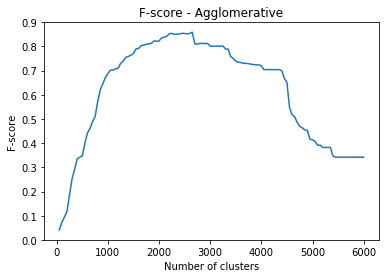

In [45]:
# Plot F-score against number of clusters
plt.plot(list(range(50, 15001, 50)), f_score_aggl_list)
plt.title('F-score - Agglomerative')
plt.xlabel('Number of clusters')
plt.ylabel('F-score')
plt.show()

In [46]:
# Find max F-score and corresponding index
max_score = max(f_score_aggl_list)
max_index = f_score_aggl_list.index(max_score)
print("Best F-score: " , max_score)
print("Index of best F-score: ", max_index)

Best F-score:  0.8585086042065009
Index of best F-score:  52


In [47]:
best_aggl_model = aggl_model_list[max_index]

In [48]:
# Get number of clusters of the best model
best_aggl_model_num_clusters = best_aggl_model.n_clusters
best_aggl_model_labels = best_aggl_model.labels_
print("Number of clusters of the best agglomerative model: ", best_aggl_model_num_clusters)

Number of clusters of the best agglomerative model:  2650


In [53]:
# save clustered data
path_to_save_data = "appr_1_clustered_data.txt"
out_cluster_file = open(path_to_save_data, "a")
for single_label in set(best_aggl_model_labels):
    indices_label = np.where(best_aggl_model_labels == single_label)[0].tolist()
    for index in indices_label:
        str_to_save = "[" + str(single_label) + "]:\t\t" + test_steps_df.loc[index]["Key"] + "\t\t" + str(step_id_text_tuple_list[index][0]) + "\t\t"+ str(test_steps_clustering_list[index]) + "\n"
        out_cluster_file.write(str_to_save)
out_cluster_file.close()

In [54]:
# save cluster labels (step IDs)
path_to_save_labels = "appr_1_cluster_labels.txt"
out_cluster_file = open(path_to_save_labels, "a")
for single_label in set(best_aggl_model_labels):
    indices_label = np.where(best_aggl_model_labels == single_label)[0].tolist()
    str_to_save = "[" + str(single_label) + "]: " + ','.join(str(step_id_text_tuple_list[x][0]) for x in indices_label) + "\n"
    out_cluster_file.write(str_to_save)
out_cluster_file.close()

In [55]:
# save list of models and F-score
model_index = 0
aggl_models_path = "results_approach_1/agglomerative_models/"
for aggl_model in aggl_model_list:
    pickle.dump(aggl_model, open(aggl_models_path + "agglomerative_model_" + str(model_index) + ".pkl", "wb"))
    model_index += 1

f_score_list_path = "results_approach_1/appr_1_f_scores.txt"
np.savetxt(f_score_list_path, np.asarray(f_score_aggl_list))

### Analysis of K-means clustering

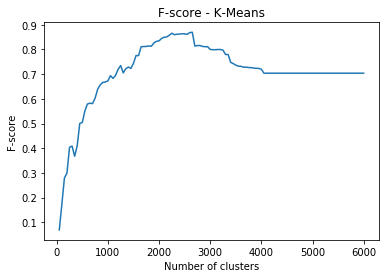

In [56]:
# Plot F-score against number of clusters
plt.plot(list(range(50, 15001, 50)), f_score_kmeans_list)
plt.title('F-score - K-Means')
plt.xlabel('Number of clusters')
plt.ylabel('F-score')
plt.show()

In [57]:
# Find max F-score and corresponding index
max_score = max(f_score_kmeans_list)
max_index = f_score_kmeans_list.index(max_score)
print("Best F-score: " , max_score)
print("Index of best F-score: ", max_index)

Best F-score:  0.8698955365622032
Index of best F-score:  52


In [58]:
best_kmeans_model = kmeans_model_list[max_index]

In [59]:
# Get number of clusters of the best model
best_kmeans_model_num_clusters = best_kmeans_model.n_clusters
best_kmeans_model_labels = best_kmeans_model.labels_
print("Number of clusters of the best k-means model: ", best_kmeans_model_num_clusters)
print("Number of non-empty clusters of the best k-means model: ", len(set(best_kmeans_model.labels_)))

Number of clusters of the best k-means model:  2650
Number of non-empty clusters of the best k-means model:  2650


In [60]:
# save clustered data
path_to_save_data = "results_approach_1_kmeans/appr_1_kmeans_clustered_data.txt"
out_cluster_file = open(path_to_save_data, "a")
for single_label in set(best_kmeans_model_labels):
    indices_label = np.where(best_kmeans_model_labels == single_label)[0].tolist()
    for index in indices_label:
        str_to_save = "[" + str(single_label) + "]:\t\t" + test_steps_df.loc[index]["Key"] + "\t\t" + str(step_id_text_tuple_list[index][0]) + "\t\t"+ str(test_steps_clustering_list[index]) + "\n"
        out_cluster_file.write(str_to_save)
out_cluster_file.close()

In [61]:
# save cluster labels (step IDs)
path_to_save_labels = "appr_1_kmeans_cluster_labels.txt"
out_cluster_file = open(path_to_save_labels, "a")
for single_label in set(best_kmeans_model_labels):
    indices_label = np.where(best_kmeans_model_labels == single_label)[0].tolist()
    str_to_save = "[" + str(single_label) + "]: " + ','.join(str(step_id_text_tuple_list[x][0]) for x in indices_label) + "\n"
    out_cluster_file.write(str_to_save)
out_cluster_file.close()

In [62]:
# save list of models and F-score
model_index = 0
kmeans_models_path = "results_approach_1/kmeans_models/"
for kmeans_model in kmeans_model_list:
    pickle.dump(kmeans_model, open(kmeans_models_path + "kmeans_model_" + str(model_index) + ".pkl", "wb"))
    model_index += 1

f_score_list_path = "results_approach_1/appr_1_kmeans_f_scores.txt"
np.savetxt(f_score_list_path, np.asarray(f_score_kmeans_list))